In [1]:
!pip install pdf2image Pillow chromadb torch torchvision torchaudio transformers librosa ipython open-clip-torch qwen_vl_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 100.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 137.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9

In [2]:
!apt-get update
!apt-get install -y poppler-utils

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,832 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,222 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 

In [3]:
!pip install -U transformers

In [4]:
import os
from pdf2image import convert_from_path
from PIL import Image
import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import torch
from transformers import CLIPProcessor, CLIPModel, WhisperProcessor, WhisperForConditionalGeneration, Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import librosa
from sentence_transformers import SentenceTransformer
from qwen_vl_utils import process_vision_info
from IPython.display import display, Image as IPImage

In [ ]:
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

In [5]:
output_dir = "dataset"
image_output_dir = "extracted_images"

def convert_pdfs_to_images(folder, image_output_dir):
    if not os.path.exists(image_output_dir):
        os.makedirs(image_output_dir)

    pdf_files = [f for f in os.listdir(folder) if f.endswith('.pdf')]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(folder, pdf_file)
        images = convert_from_path(pdf_path, dpi=100)

        image_paths = []
        for i, image in enumerate(images):
            image_path = os.path.join(image_output_dir, f"{doc_id}_page_{i}.png")
            image.save(image_path, "PNG")
            image_paths.append(image_path)

        all_images[doc_id] = image_paths
    return all_images

all_images = convert_pdfs_to_images(output_dir, image_output_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def embed_images(image_paths):
    embeddings = []
    for path in image_paths:

        image = Image.open(path)

        inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            image_embedding = model.get_image_features(**inputs).cpu().numpy()
        embeddings.append(image_embedding)
    return embeddings

image_embeddings = {}
for doc_id, paths in all_images.items():
    image_embeddings[doc_id] = embed_images(paths)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

def transcribe_audio(audio_path, chunk_length=30):
    audio, sr = librosa.load(audio_path, sr=16000)
    chunk_size = chunk_length * sr
    chunks = [audio[i:i + chunk_size] for i in range(0, len(audio), chunk_size)]

    transcription_chunks = []
    for chunk in chunks:
        inputs = whisper_processor(chunk, sampling_rate=sr, return_tensors="pt").to(device)
        inputs["attention_mask"] = torch.ones_like(inputs.input_features)
        with torch.no_grad():
            predicted_ids = whisper_model.generate(**inputs, max_length=448)
        chunk_transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        transcription_chunks.append(chunk_transcription)

    full_transcription = " ".join(transcription_chunks)
    return full_transcription, transcription_chunks

audio_files = [f for f in os.listdir(output_dir) if f.endswith('.mp3')]
audio_transcriptions = {}
for audio_id, audio_file in enumerate(audio_files):
    audio_path = os.path.join(output_dir, audio_file)
    full_transcription, transcription_chunks = transcribe_audio(audio_path)
    audio_transcriptions[audio_id] = {
        "full_transcription": full_transcription,
        "chunks": transcription_chunks
    }

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Transcription for Quick & Easy Recipes With Gordon Ramsay.mp3:  Some of the best street food of every reason was in Asia. Every one of those little markets was filled with smells of delicious food that all centered around an Asian staple, noodles. Learn to cook those properly and you'll be surprised how quick and easy it is to knock off a delicious dinner. First off, we're going to soak our noodles. Now these are rice noodles. Into a bowl and just pour a hot water over the rice noodles. Soak.  and rehydrate. 12 to 15 minutes to soften up. If you've got a wok, perfect. If not, just a normal size frying pan with big sloping sides. Pan on. Get it really nice and hot. Chicken breast, very lean, hardly any fat. On there you've got this little fillet. Just slice that off. Now, the secret to getting it really nice and thin and to cut it into strips. Take your knife, keep it nice and flat on the board and sort of  slice it in half like a sort of scallop. Like that. We call this butterfly in th

In [ ]:
client = chromadb.PersistentClient(path="chroma_db")
embedding_function = OpenCLIPEmbeddingFunction()
text_embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Delete existing collections (if needed)
try:
    client.delete_collection(name="image_collection")
    client.delete_collection(name="audio_collection")
    print("Deleted existing collections.")
except Exception as e:
    print(f"Collections do not exist or could not be deleted: {e}")

image_collection = client.create_collection(name="image_collection", embedding_function=embedding_function)
audio_collection = client.create_collection(name="audio_collection")

for doc_id, embeddings in image_embeddings.items():
    for i, embedding in enumerate(embeddings):
        image_collection.add(
            ids=[f"image_{doc_id}_{i}"],
            embeddings=[embedding.flatten().tolist()],
            metadatas=[{"doc_id": str(doc_id), "image_path": all_images[doc_id][i]}]
        )

for audio_id, transcription_data in audio_transcriptions.items():
    transcription_chunks = transcription_data["chunks"]
    for chunk_id, chunk in enumerate(transcription_chunks):
        chunk_embedding = text_embedding_model.encode(chunk)
        audio_collection.add(
            ids=[f"audio_{audio_id}_chunk_{chunk_id}"],
            embeddings=[chunk_embedding.tolist()],
            metadatas=[{
                "audio_id": str(audio_id),
                "audio_path": audio_files[audio_id],
                "chunk_id": str(chunk_id)
            }],
            documents=[chunk]
        )

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Collections do not exist or could not be deleted: Collection image_collection does not exist.


In [ ]:
def retrieve_data(query, top_k=2): 

    query_embedding_image = embedding_function([query])[0]  # OpenCLIP for image collection
    query_embedding_audio = text_embedding_model.encode(query)  # SentenceTransformer for audio collection

    image_results = image_collection.query(
        query_embeddings=[query_embedding_image],
        n_results=top_k
    )

    audio_results = audio_collection.query(
        query_embeddings=[query_embedding_audio.tolist()],
        n_results=top_k
    )

    retrieved_images = [metadata["image_path"] for metadata in image_results["metadatas"][0] if "image_path" in metadata]
    retrieved_chunks = audio_results["documents"][0] if "documents" in audio_results else []

    return retrieved_images, retrieved_chunks

query = "What are the healthiest ingredients to use in recipe you have?"
retrieved_images, retrieved_chunks = retrieve_data(query)
print("Retrieved Images:", retrieved_images)
print("Retrieved Audio Chunks:", retrieved_chunks)

Retrieved Images: ['extracted_images/0_page_3.png', 'extracted_images/0_page_12.png']
Retrieved Audio Chunks: [" Lemon. Zest the lemon. Over. Smells incredible. And then finally seal the deal with a touch of grated parmesan cheese. Give your veg some attitude and you'll get amazingly elegant dishes on a budget that are always guaranteed to impress. What more do you want from great cooking? Cheap to make, easy to cook and absolutely stunning. For me, food always has to be impressive. But when it comes to desserts,", " and one third of your protein, chicken. With a dish that takes literally minutes to put together, it's really important to get everything organized. Everything needs to be at your fingertips. Touch of olive oil. Get that pan really nice and ready. Just starting to smoke. Drop the chicken in first. Just salt, pepper. Open up those little strands of chicken."]


In [ ]:
vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
).cuda().eval()

min_pixels = 256 * 256
max_pixels = 1024 * 1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    min_pixels=min_pixels,
    max_pixels=max_pixels
)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
chat_template = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": retrieved_images[0]},  # First retrieved image
            {"type": "image", "image": retrieved_images[1]},  # Second retrieved image
            {"type": "text", "text": query},  # User query
            {"type": "text", "text": "Audio Context: " + " ".join(retrieved_chunks)}  # Include audio data
        ],
    }
]

text = vl_model_processor.apply_chat_template(
    chat_template, tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to("cuda")

generated_ids = vl_model.generate(**inputs, max_new_tokens=100)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text[0])

The healthiest ingredients to use in the recipe are:

1. **Lemon** - Provides a burst of citrus flavor and is a good source of vitamin C.
2. **Parmesan Cheese** - A good source of calcium and protein.
3. **Chicken** - A lean protein source that is rich in essential amino acids.
4. **Olive Oil** - A healthy fat that is rich in monounsaturated fatty acids.
5. **Zest** - Adds a burst of flavor


In [ ]:
from PIL import Image
from IPython.display import display

# Function to display retrieved images
def display_retrieved_images(retrieved_images):
    for image_path in retrieved_images:
        try:
            # Open the image using PIL
            img = Image.open(image_path)
            print(f"Displaying image: {image_path}")
            display(img)  # Display the image in a notebook or GUI
        except Exception as e:
            print(f"Error displaying image {image_path}: {e}")


Displaying image: extracted_images/0_page_3.png


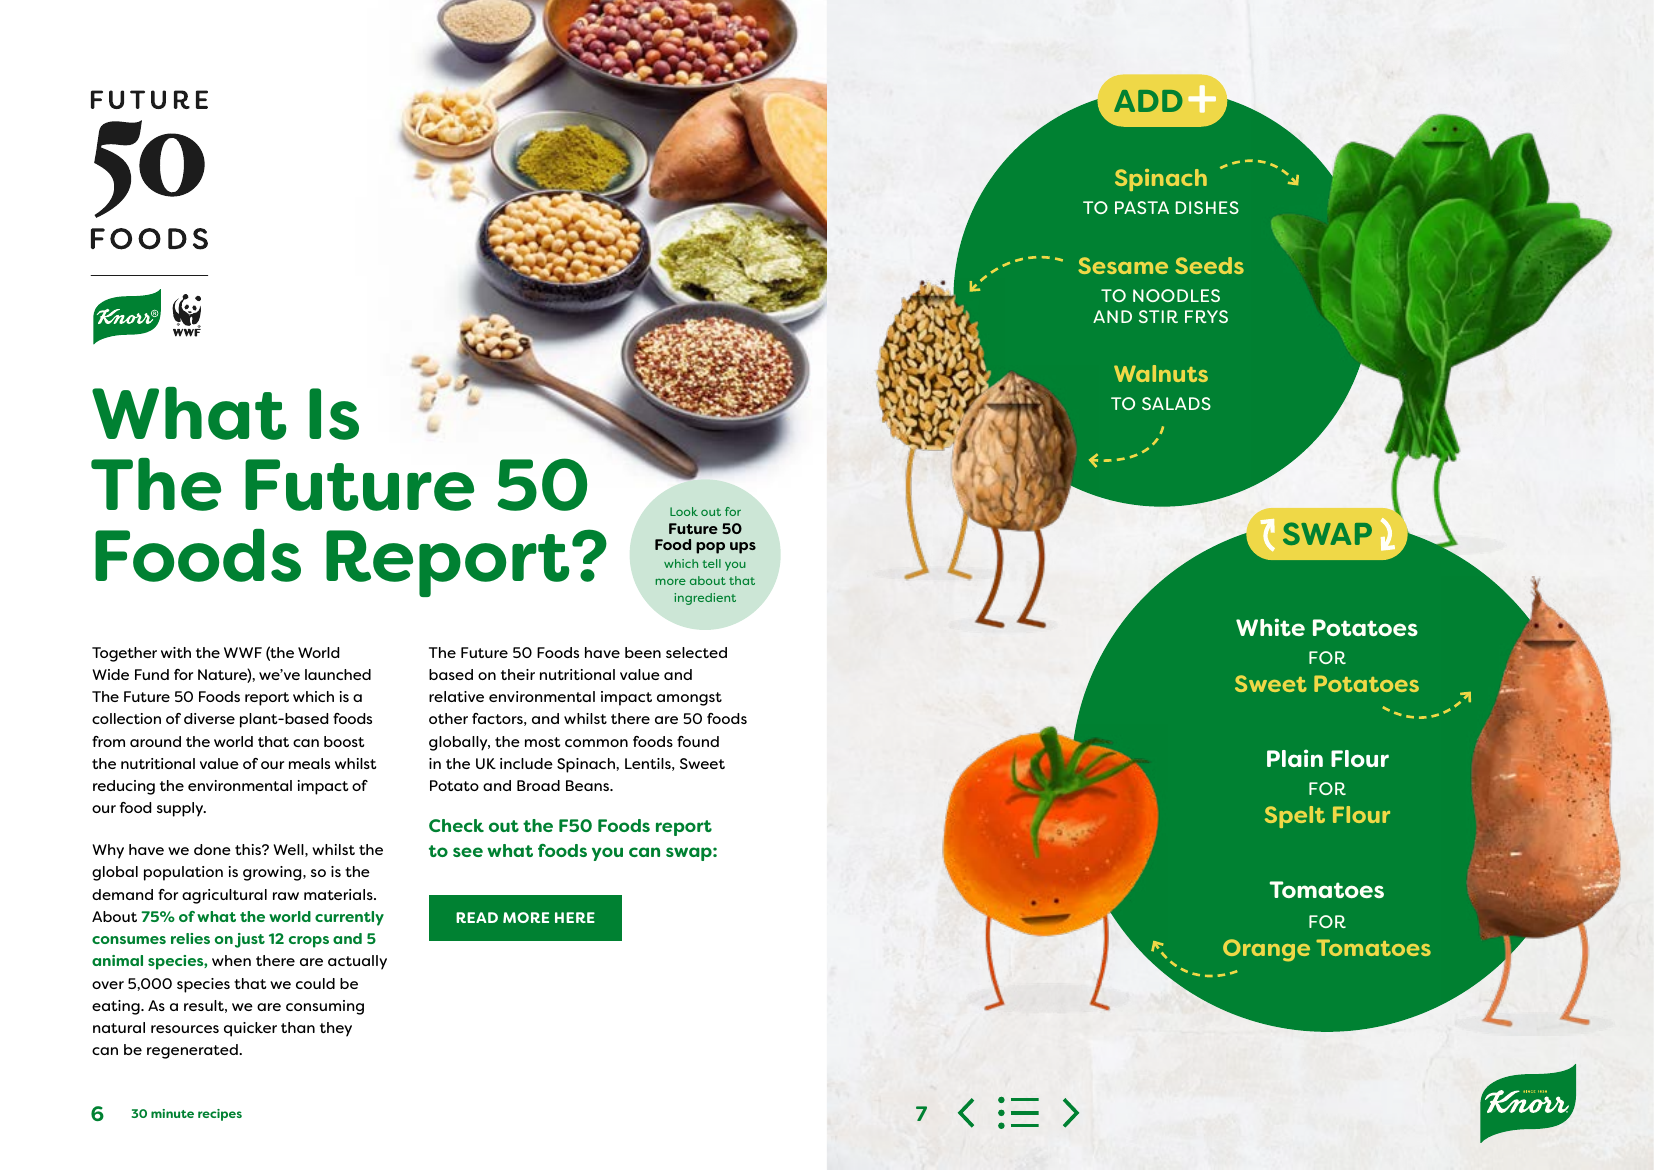

Displaying image: extracted_images/0_page_12.png


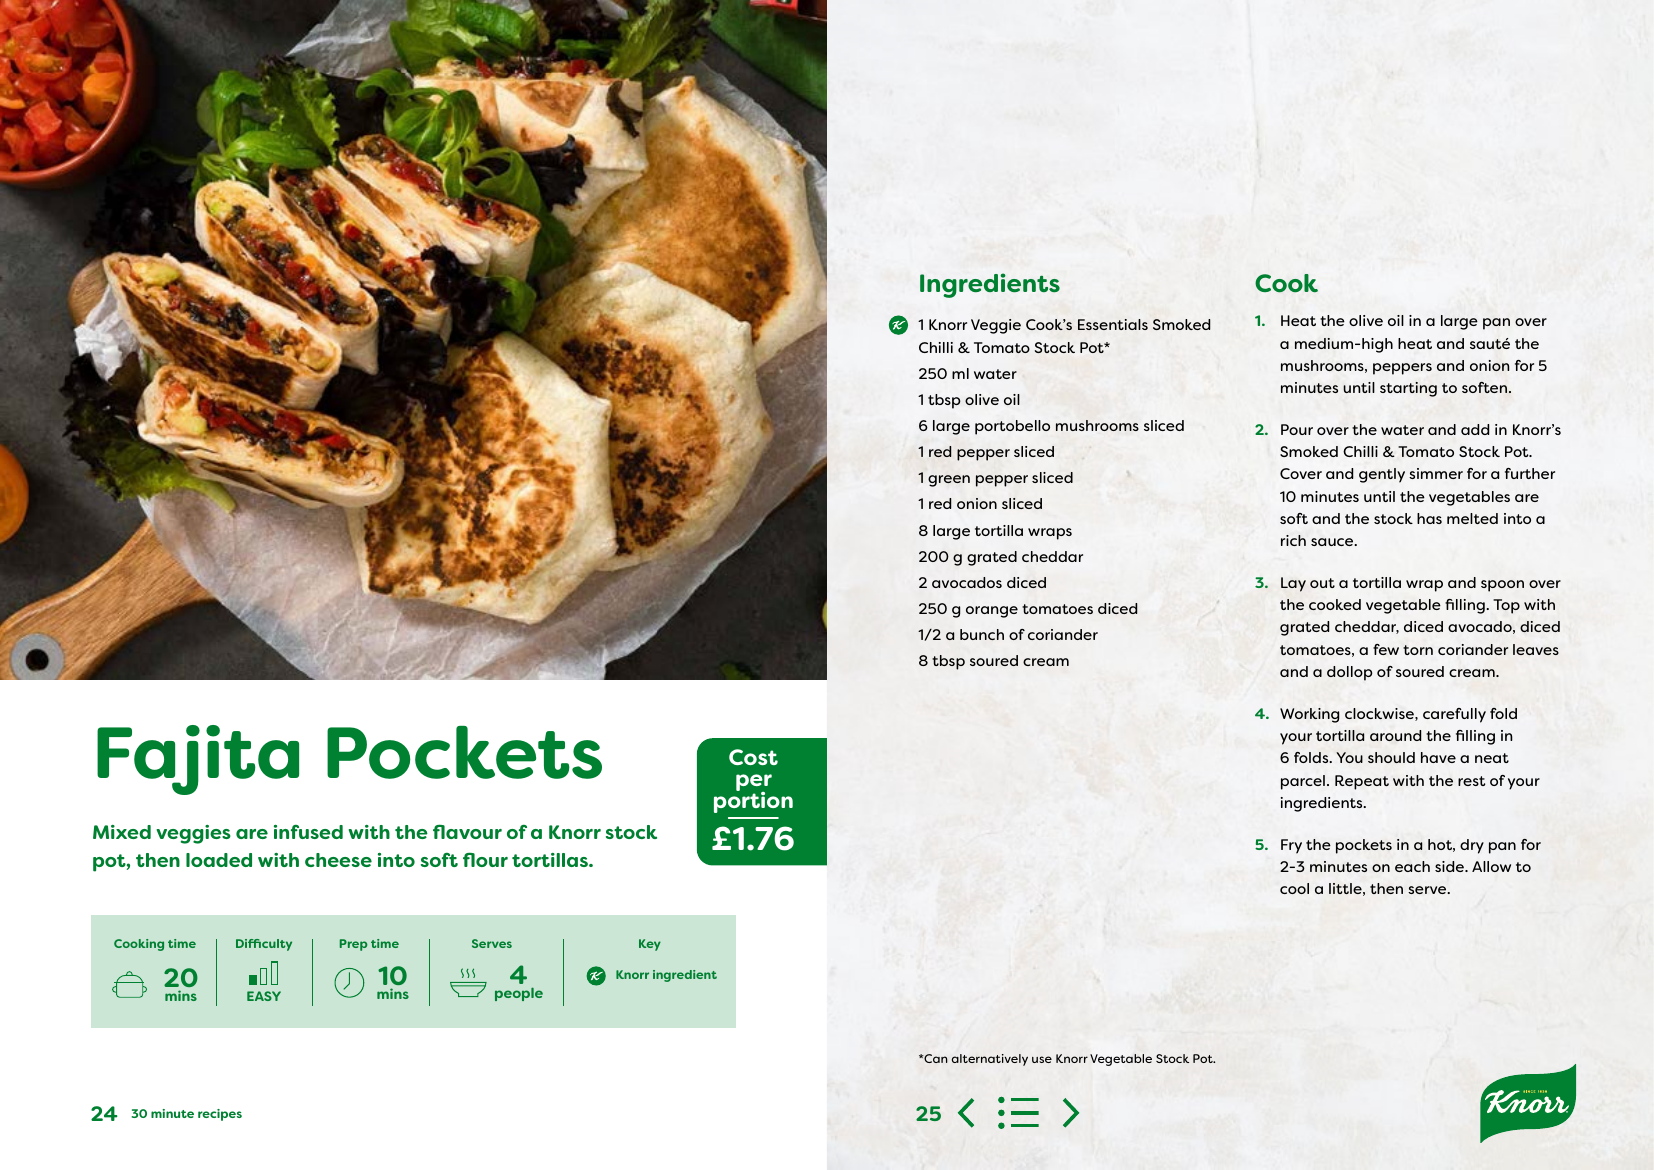

In [ ]:
display_retrieved_images(retrieved_images)

In [6]:
# ================================================================
#   FULL MULTIMODAL RAG SYSTEM IN ONE CLEAN NOTEBOOK BLOCK
#   Includes: PDF→Images → Embeddings → ChromaDB → Retrieval → 
#             Qwen2-VL Generation → Display Images
# ================================================================

# ------------------ IMPORTS -------------------------------------
import os
import torch
import librosa
from PIL import Image
from pdf2image import convert_from_path
from IPython.display import display

import chromadb
from chromadb.config import Settings

from transformers import (
    CLIPModel, CLIPProcessor,
    WhisperProcessor, WhisperForConditionalGeneration,
    Qwen2VLForConditionalGeneration, Qwen2VLProcessor
)

from sentence_transformers import SentenceTransformer
from qwen_vl_utils import process_vision_info

# ------------------ DEVICE SETUP -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ------------------ LOAD MODELS -------------------------------
# CLIP for images
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Whisper for audio → text
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

# MiniLM for text embeddings
text_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Qwen2-VL for FINAL generation
vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
).cuda().eval()

vl_processor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct",
                                                min_pixels=256*256,
                                                max_pixels=1024*1024)

# ------------------ CREATE VECTOR DB ----------------------------
client = chromadb.PersistentClient(path="chroma_db")
try:
    client.delete_collection("images")
    client.delete_collection("audio")
except:
    pass

image_collection = client.create_collection("images")
audio_collection = client.create_collection("audio")

# ------------------ PDF → IMAGE FUNCTION ------------------------
def convert_pdfs_to_images(pdf_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf in enumerate(pdf_files):
        pages = convert_from_path(os.path.join(pdf_folder, pdf), dpi=100)
        paths = []
        for i, img in enumerate(pages):
            img_path = f"{out_folder}/{doc_id}_page_{i}.png"
            img.save(img_path)
            paths.append(img_path)
        all_images[doc_id] = paths
    return all_images

# ------------------ IMAGE EMBEDDING -----------------------------
def embed_images(image_paths):
    embeddings = []
    for path in image_paths:
        img = Image.open(path)
        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs).cpu().numpy().flatten()
        embeddings.append(emb)
    return embeddings

# ------------------ AUDIO TRANSCRIPTION -------------------------
def transcribe_audio(audio_path, chunk_sec=30):
    audio, sr = librosa.load(audio_path, sr=16000)
    chunk_size = chunk_sec * sr
    chunks = [audio[i:i+chunk_size] for i in range(0, len(audio), chunk_size)]

    text_chunks = []
    for ch in chunks:
        inputs = whisper_processor(ch, sampling_rate=sr, return_tensors="pt").to(device)
        inputs["attention_mask"] = torch.ones_like(inputs.input_features)
        with torch.no_grad():
            ids = whisper_model.generate(**inputs, max_length=448)
        text_chunks.append(whisper_processor.batch_decode(ids, skip_special_tokens=True)[0])

    return " ".join(text_chunks), text_chunks

# ------------------ RETRIEVAL ----------------------------------
def retrieve_data(query, top_k=2):
    q_img = clip_processor(text=query, return_tensors="pt").input_ids  # dummy to trigger image embedding
    q_img_emb = text_model.encode(query)  # fallback if CLIP embedding fn unavailable

    q_txt_emb = text_model.encode(query)

    # image search
    img_res = image_collection.query(query_embeddings=[q_img_emb], n_results=top_k)
    retrieved_imgs = [m["image_path"] for m in img_res["metadatas"][0]]

    # audio search
    aud_res = audio_collection.query(query_embeddings=[q_txt_emb.tolist()], n_results=top_k)
    retrieved_text = aud_res["documents"][0]

    return retrieved_imgs, retrieved_text

# ------------------ FINAL MULTIMODAL GENERATION ----------------
def generate_answer(query, retrieved_images, retrieved_audio_chunks):

    chat = [{
        "role": "user",
        "content": [
            {"type": "image", "image": retrieved_images[0]},
            {"type": "image", "image": retrieved_images[1]},
            {"type": "text", "text": query},
            {"type": "text", "text": "Audio Context: " + " ".join(retrieved_audio_chunks)},
        ],
    }]

    text_prompt = vl_processor.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

    img_inputs, _ = process_vision_info(chat)

    inputs = vl_processor(
        text=[text_prompt],
        images=img_inputs,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        out = vl_model.generate(**inputs, max_new_tokens=120)

    trimmed = [
        o[len(i):] for i, o in zip(inputs.input_ids, out)
    ]

    return vl_processor.batch_decode(trimmed, skip_special_tokens=True)[0]

# ------------------ DISPLAY IMAGES ------------------------------
def display_images(paths):
    for p in paths:
        print("Image:", p)
        display(Image.open(p))

# ------------------ PIPELINE EXECUTION (EXAMPLE) ----------------
# 1. Set folders
pdf_folder = "dataset"
img_out = "extracted_images"

# 2. Convert PDFs
all_images = convert_pdfs_to_images(pdf_folder, img_out)

# 3. Embed images & store in ChromaDB
for doc_id, imgs in all_images.items():
    emb = embed_images(imgs)
    for i, e in enumerate(emb):
        image_collection.add(
            ids=[f"img_{doc_id}_{i}"],
            embeddings=[e.tolist()],
            metadatas=[{"image_path": imgs[i]}]
        )

# 4. Process audio files
audio_files = [f for f in os.listdir(pdf_folder) if f.endswith(".mp3")]
audio_data = {}
for aid, afile in enumerate(audio_files):
    full, chunks = transcribe_audio(os.path.join(pdf_folder, afile))
    audio_data[aid] = chunks
    for cid, chunk in enumerate(chunks):
        emb = text_model.encode(chunk)
        audio_collection.add(
            ids=[f"aud_{aid}_{cid}"],
            embeddings=[emb.tolist()],
            documents=[chunk],
            metadatas=[{"audio_file": afile}]
        )

# 5. Run query
query = "What are the healthy ingredients mentioned in the content?"
retrieved_imgs, retrieved_chunks = retrieve_data(query)

# 6. Display retrieved images
display_images(retrieved_imgs)

# 7. Generate final answer
answer = generate_answer(query, retrieved_imgs, retrieved_chunks)
print("\nFINAL ANSWER:\n", answer)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 16.12 MiB is free. Process 7706 has 14.72 GiB memory in use. Of the allocated memory 14.28 GiB is allocated by PyTorch, and 355.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)